Дубовик Егор, 3 группа, вариант 1, тема - Выдача кредитов

In [101]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import *
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None  # default='warn'

In [102]:
df = pd.read_csv("train.csv")
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [103]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


Преобразуем входные данные

In [104]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)
df['LoanAmount'] = df['LoanAmount'].replace(np.nan, 0)
types=['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
for var in types:
    le = preprocessing.LabelEncoder()
    df[var]=le.fit_transform(df[var].astype('str'))

Собственно классификатор по алгоритму 1

In [105]:
class Classifier:
    def __init__(self, dist_function=np.linalg.norm):
        self.__dist_function = dist_function

    def fit(self, X, y):
        self.__X_param = np.array(X)
        self.__y_param = np.array(y)
        self.__class_labels = list(set(y))
        return self

    def predict(self, X):
        X = np.array(X)

        dist_matrix = np.array([
            [
                self.__dist_function(xp - xt)
                for xp in self.__X_param
            ]
            for xt in X
        ])
        
        #находим точку до которой расстояние минимально
        b_matrix = np.array([
            [
                dist_matrix[idx][self.__y_param == class_label].mean()
                for class_label in self.__class_labels
            ]
            for idx in range(len(X))
        ])

        return b_matrix.argmin(axis=1)

Попробуем пооставлять разные колонки, посмотрим как будет меняться точность

In [106]:
def process(var, df):
    new_df = df[var]
    #отнормируем
    for name in new_df.columns:
        if name == 'Loan_ID' or name == 'Loan_Status':
            continue
        new_df.loc[:,name] *= 1.0 / new_df[name].max()
    col_names = [name for name in new_df.columns if name != 'Loan_Status']
    X = new_df[col_names].values
    y = [1 if c == 'Y' else 0 for c in new_df['Loan_Status']]
    
    #разбиваем на 3 группы: обучающую, тестовую и группу для кросс-валидации
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=2, stratify=y_train)

    classifier = Classifier(dist_function=np.linalg.norm).fit(X_train, y_train)

    y_pred = classifier.predict(X_val)
    print("для колонок: ", var)
    print("Точность на валидационной выборке:", accuracy_score(y_val, y_pred))
    y_pred = classifier.predict(X_test)
    print("Точность на тестовой выборке:", accuracy_score(y_test, y_pred))
    
process(['Education', 'Self_Employed', 'TotalIncome', 'Loan_Status'], df)
process(['Gender', 'Education', 'Self_Employed','TotalIncome', 'Loan_Status'], df)
process(['Credit_History', 'Loan_Status'], df)
process(['Gender', 'Loan_Status'], df)
process(['Gender', 'Credit_History', 'Loan_Status'], df)

для колонок:  ['Education', 'Self_Employed', 'TotalIncome', 'Loan_Status']
Точность на валидационной выборке: 0.6060606060606061
Точность на тестовой выборке: 0.6910569105691057
для колонок:  ['Gender', 'Education', 'Self_Employed', 'TotalIncome', 'Loan_Status']
Точность на валидационной выборке: 0.5656565656565656
Точность на тестовой выборке: 0.5934959349593496
для колонок:  ['Credit_History', 'Loan_Status']
Точность на валидационной выборке: 0.8282828282828283
Точность на тестовой выборке: 0.8373983739837398
для колонок:  ['Gender', 'Loan_Status']
Точность на валидационной выборке: 0.6161616161616161
Точность на тестовой выборке: 0.5934959349593496
для колонок:  ['Gender', 'Credit_History', 'Loan_Status']
Точность на валидационной выборке: 0.8282828282828283
Точность на тестовой выборке: 0.8373983739837398


Таким образом, гендер не важен, а кредитная история важна

Вот еще t-SNE, построенные по координатам указанных колонок, но по ним видно что все объекты разбиваются на классы(потому что у нас есть изначально булевские признаки), а в классах все достаточно плотно

для колонок:  ['Education', 'Self_Employed', 'TotalIncome', 'Loan_Status']


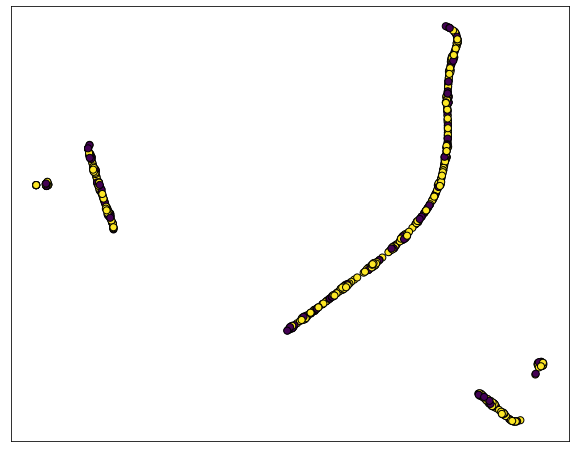

для колонок:  ['Gender', 'Education', 'Self_Employed', 'TotalIncome', 'Loan_Status']


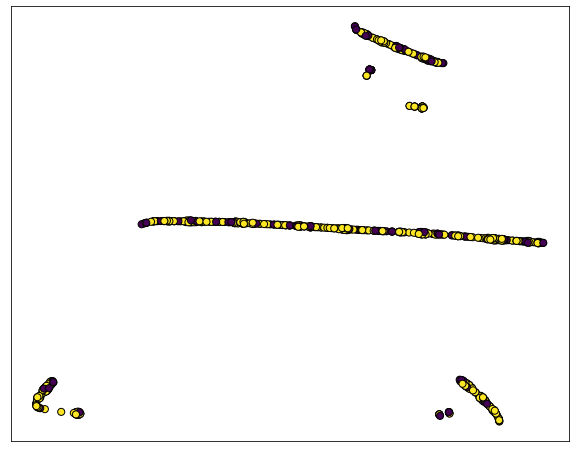

для колонок:  ['Credit_History', 'Loan_Status']


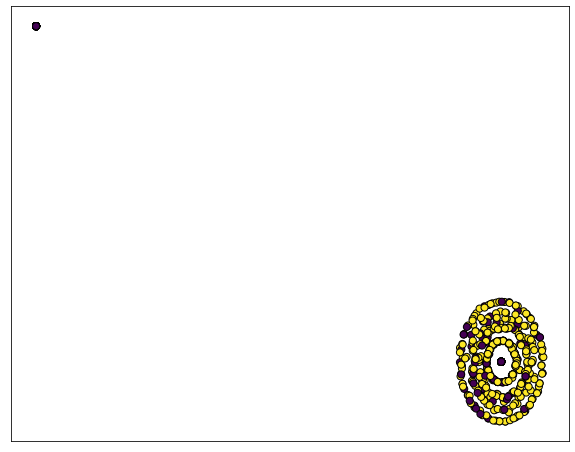

для колонок:  ['Gender', 'Loan_Status']


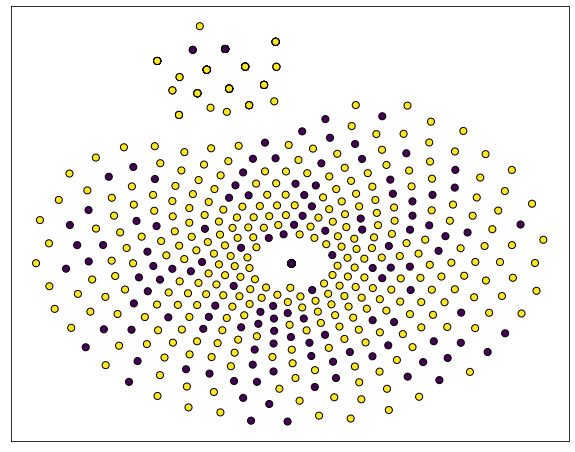

для колонок:  ['Gender', 'Credit_History', 'Loan_Status']


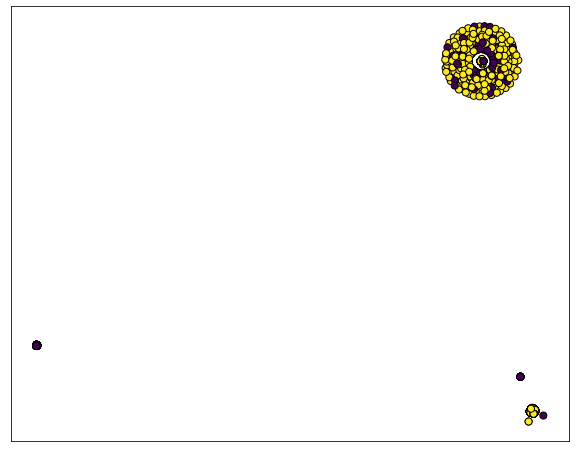

In [107]:
def draw_pictures(var, df):
    new_df = df[var]
    for name in new_df.columns:
        if name == 'Loan_ID' or name == 'Loan_Status':
            continue
        new_df.loc[:,name] *= 1.0 / new_df[name].max()
    col_names = [name for name in new_df.columns if name != 'Loan_Status']
    X = new_df[col_names].values
    y = [1 if c == 'Y' else 0 for c in new_df['Loan_Status']]
    
    X_embedded = TSNE(n_iter=4000).fit_transform(X)

    print("для колонок: ", var)
    plt.figure(1, figsize=(10, 8))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, zorder=10, s=50, edgecolor='black')
    plt.xticks(())
    plt.yticks(())
    plt.show()

draw_pictures(['Education', 'Self_Employed', 'TotalIncome', 'Loan_Status'], df)
draw_pictures(['Gender', 'Education', 'Self_Employed','TotalIncome', 'Loan_Status'], df)
draw_pictures(['Credit_History', 'Loan_Status'], df)
draw_pictures(['Gender', 'Loan_Status'], df)
draw_pictures(['Gender', 'Credit_History', 'Loan_Status'], df)